#  Proyecto Final  

Autores:

   * Pablo Izquierdo Conde
   * Jorge Pose Eiroa

Fecha: 26-12-2018

# 1.Obtención de categorías

La primera parte del Proyecto consiste en obtener las páginas con las que vamos a trabajar. Para ello seleccionamos dos categorías de la Wikipedia, que en nuestro caso, y por ser las categorías iniciales muy disjuntas, el profesor nos ha permitido escoger dos subcategorías de la categoría `Sports`.

In [30]:
import wikipediaapi as wk
import numpy as np
import copy

wiki = wk.Wikipedia('en')

# Cogemos las categorías seleccionadas
cat0 = wiki.page("Category:Esports")
cat1 = wiki.page("Category:Combat_sports")

Una vez seleccionadas las categorías es necesario obtener las páginas que cuelgan de ellas, así como algunas de las páginas que cuelgan de las subcategorías de las categorías elegidas. Esto es lo que hace la siguiente función, a la que le hemos puesto una profundidad de 3 niveles, que es más que suficiente para obtener el número de páginas necesarias.

In [31]:
# Función que busca recursivamente en las categorías y nos devuelve una lista con las páginas
def print_categorymembers(categorymembers, level=0, max_level=2, pages = []):
    for c in categorymembers.values():
        if c.ns == 0: # Sacamos las páginas (ns=0)
            pages.append(c)
        if c.ns == wk.Namespace.CATEGORY and level <= max_level:
            print_categorymembers(c.categorymembers, level + 1,1, pages)
p0 = [] #len=1227
p1 = []#len=4288
print_categorymembers(cat0.categorymembers,0,1, p0)
print_categorymembers(cat1.categorymembers,0,1, p1)

Una vez obtenidas las páginas, procedemos a obtener el texto que usaremos como corpus para el resto del proyecto, tomando 500 páginas aleatorias de cada categoría. Este proceso va a llevar un rato, ya que es necesario recorrer todas las páginas y descargar el texto.

In [32]:
indices0 = np.random.permutation(len(p0))
indices1 = np.random.permutation(len(p1))

indices0_train = indices0[:500]
indices1_train = indices1[:500]

# Sacamos el texto de las listas de páginas
corpus0 = []
corpus1 = []

# Corpus 0 train
print('Corpus 0')
for n,i in enumerate(indices0_train):
    if not n%100:
        print('\rPage', n, 'out of', len(indices0_train), end='', flush=True)
    corpus0.append(p0[i].text)
     
# Corpus 1 train    
print('\nCorpus 1')
for n,i in enumerate(indices1_train):
    if not n%100:
        print('\rPage', n, 'out of', len(indices1_train), end='', flush=True)
    corpus1.append(p1[i].text)

corpustotal=copy.deepcopy(corpus0)
corpustotal.extend(corpus1)

Corpus 0
Page 400 out of 500
Corpus 1
Page 400 out of 500

Al usar el método `text` sobre las distintas páginas obtenemos directamente el contenido del artículo en texto plano, y además se elimina la sección de `Categories` y otras que pudieran interferir con los restultados, como `References`.

Puede comprobarse que esto es así imprimiendo cualquier página de las guardadas en `corpustotal`.

In [33]:
print(corpustotal[921])

There are a large number of distinct styles and schools of martial arts.  Sometimes, schools or styles are introduced by individual teachers or masters, or as a brand name by a specific gym. Martial arts can be grouped by type or focus, or alternatively by regional origin. This article focuses on the latter grouping.
For hybrid martial arts, as they originated from the late 19th century and especially after 1950, it may be impossible to identify unique or predominant regional origins.  It is not trivial to distinguish "traditional" from "modern" martial arts. Chronology is not the decisive criterion, as, for example, "traditional taekwondo" was developed in the 1950s, while the "modern" hybrid martial art of Bartitsu was developed in ca. 1900.
A large portion of traditional martial arts can be categorized as folk wrestling (see the separate article), although in some cases a folk wrestling style and a modern combat sport may overlap or become indistinguishable from each other once the 

# 2. Procesado de texto

Para la parte de procesador de texto se va a usar NLTK y van a seguirse los siguientes pasos:
    1. Tokenization
    2. Homogeneization
    3. Cleaning
    4. Vectorization
    
Una vez terminado este proceso, se obtendrá la `Bag-of-Words` correspondiente al `corpus`, que se introducirá en modelo LDA

In [34]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim

wnl = WordNetLemmatizer()
stopwords_en = stopwords.words('english')
palabros = ['wa','also','ha'] # Después de ver los resultados hemos añadido más palabras a las stopwords
stopwords_en.extend(palabros)

In [35]:
# Esta función va a limpiarnos el corpus realizando la tokenización, la lemmatización y la eliminación de stopwords
def getCorpusClean(corpus):
    corpus_clean=[]
    for text in corpus:
        tokens = word_tokenize(text)
        tokens_filtered = [el.lower() for el in tokens if el.isalnum() and not el.isdigit()] # Nos quedamos solo con palabras, quitamos numeros
        tk_lemmat = [wnl.lemmatize(el) for el in tokens_filtered]
        tk_clean = [tk for tk in tk_lemmat if tk not in stopwords_en]
        corpus_clean.append(tk_clean)
    return corpus_clean

corpus_clean = getCorpusClean(corpustotal)

In [36]:
# Con esta función obtenemos la Bag-of-Words a partir del corpus limpio
def getCorpusBow(corpus_clean, no_below = 5, no_above = .75):
    D = gensim.corpora.Dictionary(corpus_clean)
    D.filter_extremes(no_below=no_below, no_above=no_above, keep_n=25000)
    corpus_bow = [D.doc2bow(doc) for doc in corpus_clean]
    return corpus_bow, D
    
corpus_bow, D = getCorpusBow(corpus_clean)

# 3. Modelado de tópicos con LDA

El modelado de tópicos se realiza teniendo en cuenta los documentos de ambas categorías, para generar así tópicos que permitan distinguir documentos pertenecientes a una y a otra.

In [37]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel

# Función que nos genera el modelo LDA a partir de la BOW y el número de tópicos
def getLDAModel(corpus_bow, D, num_topics):
    ldag = gensim.models.ldamodel.LdaModel(corpus=corpus_bow, id2word=D, num_topics = num_topics, passes=20)
    return ldag

num_topics = 50
ldag = getLDAModel(corpus_bow, D, num_topics)

Para la elección del número de tópicos se ha realizado un análisis del efecto que esto tiene en la coherencia de los tópicos:

In [38]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=ldag, texts=corpus_clean, dictionary=D, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4520582484680365


In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

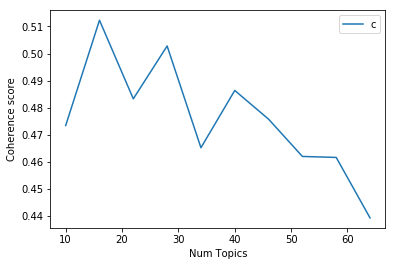

In [40]:
# Show graph
import matplotlib.pyplot as plt
limit=70; start=10; step=6;
model_list, coherence_values = compute_coherence_values(dictionary=D, corpus=corpus_bow, texts=corpus_clean, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

A partit de la gráfica nos quedamos con el modelo que tiene el número de tópicos con el valor de coherencia más alto

In [56]:
ldag=model_list[np.argmax(coherence_values)]

16

Para visualizar de una manera más clara los tópicos se traza el siguiente gráfico. En este se observa como los tópicos que sobresalen en la misma categoría se encuentran más próximos, y la influencia de cada término en los distintos tópicos (y por ende en las categorías).

In [42]:
def visTopics(ldag, corpus_bow, D):    
    vis_data = gensimvis.prepare(ldag, corpus_bow, D)
    return pyLDAvis.display(vis_data)   

visTopics(ldag, corpus_bow, D)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


Una vez hallados los tópicos, es necesario pasarlos a una matriz para poder ser utilizados por el clasificador.

In [57]:
# Esta función nos devuelve la matriz extendida a partir de la matriz dispersa que nos da el modelo
def getExpandedMatrix(corpus_bow, ldag, num_topics):
        reduced_corpus = [el for el in ldag[corpus_bow[:]]]
        X = gensim.matutils.corpus2dense(reduced_corpus, num_topics).T
        return X


Xtotal = getExpandedMatrix(corpus_bow, ldag, ldag.num_topics)

y0 = np.zeros((500,1)) #antes 1000
y1 = np.ones((500,1)) #antes 1000
Stotal = np.vstack((y0,y1))

In [58]:
print(Xtotal.shape)

(1000, 16)


# 4. Implementación del clasificador

Una vez obtenida la matriz de entrenamiento, se procede a entrenar un clasificador. En nuestro caso hemos utilizado uno de tipo `SVM`con kernel `rbf`. 

In [59]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import sklearn.model_selection as modselect
from sklearn.metrics import mean_squared_error, accuracy_score

X_tr, X_test, S_tr, S_test = modselect.train_test_split(Xtotal, Stotal, test_size=0.20, random_state=42)

In [60]:
svcparams = {'C': [100, 200, 350, 500, 1000, 1200, 1500 ],
     'gamma': [0.3, 0.5, 0.7, 0.9, 1.1]}

clf = svm.SVC(kernel = 'rbf')
svcGrid = modselect.GridSearchCV(clf, svcparams, cv=20, verbose=1, scoring='accuracy', n_jobs=-2).fit(Xtotal,np.ravel(Stotal))

Fitting 20 folds for each of 35 candidates, totalling 700 fits


[Parallel(n_jobs=-2)]: Done 234 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 700 out of 700 | elapsed:    2.9s finished


In [61]:
print('best accuracy score', svcGrid.best_score_)
print('best_params', svcGrid.best_params_)

best accuracy score 0.952
best_params {'C': 500, 'gamma': 0.9}


In [62]:
clf = svcGrid.best_estimator_
clf.fit(X_tr,np.ravel(S_tr))

print('Accuracy: ',accuracy_score(S_test, clf.predict(X_test)))

Accuracy:  0.93


Una vez hecho el clasificador, obtenemos un conjunto de test de 200 artículos por categoría

In [63]:
indices0_test = indices0[500:700]
indices1_test = indices1[500:700]
# Sacamos el texto de las listas de páginas
corpus0 = []
corpus1 = []

# Corpus 0 test
print('Corpus 0')
for n,i in enumerate(indices0_test):
    if not n%100:
        print('\rPage', n, 'out of', len(indices0_test), end='', flush=True)
    corpus0.append(p0[i].text)
     
# Corpus 1 test  
print('\nCorpus 1')
for n,i in enumerate(indices1_test):
    if not n%100:
        print('\rPage', n, 'out of', len(indices1_test), end='', flush=True)
    corpus1.append(p1[i].text)

corpusTest=copy.deepcopy(corpus0)
corpusTest.extend(corpus1)

Corpus 0
Page 100 out of 200
Corpus 1
Page 100 out of 200

In [64]:
print(len(corpusTest))

400


In [71]:
corpus_test_clean = getCorpusClean(corpusTest)
#corpus_test_bow, D2 = getCorpusBow(corpus_test_clean)
corpus_test_bow = [D.doc2bow(doc) for doc in corpus_test_clean]
#ldag_test = getLDAModel(corpus_test_bow, D2, num_topics)

Xtest = getExpandedMatrix(corpus_test_bow, ldag, ldag.num_topics)

y0 = np.zeros((200,1))
y1 = np.ones((200,1))
Stest = np.vstack((y0,y1))

In [72]:
print(Xtest.shape)

(400, 16)


In [73]:
clf.fit(Xtotal, np.ravel(Stotal))
print('Accuracy: ',accuracy_score(Stest, clf.predict(Xtest)))

Accuracy:  0.96
